https://github.com/bluets-inlondon/DMHR/

# Assignment A
Data used in this section are available at: 
- https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/patients-registered-at-a-gp-practice-april-2018-special-topic---registered-patients-compared-to-the-projected-resident-population-in-england and
- https://digital.nhs.uk/data-and-information/publications/statistical/practice-level-prescribing-data/april-2018

In [143]:
#preliminaries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import scipy as sp
from scipy.stats import norm

In [144]:
#Custom column names for the practice information file
cols = ['timePeriod', 'practice_code', 'practice_name', 'practice_organization', 'street', 'city', 'area', 'postcode']

In [145]:
#load practice information csv file as a pandas DataFrame
practices = pd.read_csv('T201804ADDR+BNFT.csv', sep=',',header=None, names=cols,index_col=False)

In [146]:
#Explore data using different methods: info, head, tail, describe, dytpes
practices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 8 columns):
timePeriod               9578 non-null int64
practice_code            9578 non-null object
practice_name            9578 non-null object
practice_organization    9578 non-null object
street                   9578 non-null object
city                     9578 non-null object
area                     9578 non-null object
postcode                 9578 non-null object
dtypes: int64(1), object(7)
memory usage: 598.7+ KB


##### The dataframe has 8 columns with 9578 rows. All columns are of dtype 'object' except for 'timePeriod'.  timePeriod could be converted to dtype:datetime64 if required but this column won't be needed in the analysis since all data are from the same month. Other dtypes are apppropriate as these indicate strings in a pandas.

In [147]:
practices.head()

,timePeriod,practice_code,practice_name,practice_organization,street,city,area,postcode
0,201804,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 1HU
1,201804,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
2,201804,A81004,BLUEBELL MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,TS5 8SB
3,201804,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ
4,201804,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 2AT


In [148]:
practices.tail()

,timePeriod,practice_code,practice_name,practice_organization,street,city,area,postcode
9573,201804,Y06062,IMPROVED ACCESS GLOUCESTER INNER CITY,PAVILION FAMILY DOCTORS,153A STROUD ROAD,GLOUCESTER,GLOUCESTERSHIRE,GL1 5JJ
9574,201804,Y06063,ABOUT HEALTH LTD,EVOLUTION PARK,HASLINGDEN ROAD,BLACKBURN,LANCASHIRE,BB1 2FD
9575,201804,Y06066,ROYAL SURREY (CEDAR CTR)-FREESTYLE LIBRE,C/O CEDAR CENTRE,ROYAL SURREY COUNTY HOSP,GUILDFORD,SURREY,GU2 7XX
9576,201804,Y06070,RICHMOND LEARNING DISABILITY,YH RICHMOND LD SERVICE,26 UPPER TEDDINGTON ROAD,HAMPTON WICK,,KT1 4DY
9577,201804,Y06073,BARKING DRUG & ALCOHOL RECOVERY,ST LUKE'S CENTRE,88 DAGENHAM ROAD,ROMFORD,,RM10 7UP


In [149]:
practices.describe(include=['O']) # to identify any obvious issues related to missing data or duplicates. 

,practice_code,practice_name,practice_organization,street,city,area,postcode
count,9578,9578,9578,9578,9578,9578,9578
unique,9578,9034,7771,7233,2444,402,7569
top,C84060,DR LOCAL CARE DIRECT OOH,THE SURGERY,,,,SW20 8DA
freq,1,8,322,688,363,1918,20


#### Note that from inspection of the head and tail it's clear that the dataframe has some missing data in 'area' column. This is confirmed from the "describe" analysis where we can see that there are a lot of missing data in the 'street', 'city' and 'area' columns indicated by white space. Decisions on what to do with these missing depend on the analysis required and will be addressed in sections below.

In [150]:
practices.head()

,timePeriod,practice_code,practice_name,practice_organization,street,city,area,postcode
0,201804,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 1HU
1,201804,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
2,201804,A81004,BLUEBELL MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,TS5 8SB
3,201804,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ
4,201804,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 2AT


In [151]:
#Custom column names for the gp prescribing information file
cols2 = ['sha', 'pct', 'practice_code', 'bnf_code', 'bnf_name', 'items', 'nic', 'act_cost', 'quantity', 'timeperiod']

In [152]:
#load the Gp prescribing information csv file as a pandas DataFrame. Strip the headings of white space using a lambda function.
prescribing =  pd.read_csv('T201804PDPI+BNFT.csv', header=None, names=cols2, index_col=False, skiprows=1).rename(columns=lambda x: x.strip())

In [153]:
#Explore data as above using different methods: info, head, tail, describe, dytpes
prescribing.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9748354 entries, 0 to 9748353
Data columns (total 10 columns):
sha              9748354 non-null object
pct              9748354 non-null object
practice_code    9748354 non-null object
bnf_code         9748354 non-null object
bnf_name         9748354 non-null object
items            9748354 non-null int64
nic              9748354 non-null float64
act_cost         9748354 non-null float64
quantity         9748354 non-null int64
timeperiod       9748354 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 743.7+ MB


In [154]:
prescribing.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,timeperiod
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804


In [155]:
prescribing.tail()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,timeperiod
9748349,Q70,99M,Y03585,1103010C0AAAAAA,Chloramphen_Eye Dps 0.5%,1,1.14,1.07,10,201804
9748350,Q70,99M,Y04164,0106040G0AAAAAA,Lactulose_Soln 3.1g-3.7g/5ml,1,2.32,2.16,500,201804
9748351,Q70,99M,Y04164,1310020N0AAAAAA,Miconazole Nit_Crm 2%,1,1.82,1.70,30,201804
9748352,Q70,99M,Y04164,21220000205,Hydromol Oint,1,4.92,4.58,500,201804
9748353,Q70,99M,Y04323,0106040R0BBAAAF,Micralax_Micro-Enem 5ml,1,1.22,1.24,3,201804


In [156]:
prescribing.describe(include=['O']) #include dtypes objects

,sha,pct,practice_code,bnf_code,bnf_name
count,9748354,9748354,9748354,9748354,9748354
unique,27,397,9578,22358,19227
top,Q46,15E,M85063,0603020T0AAACAC,GlucoRX FinePoint Needles Pen Inj Screw
freq,615496,227462,4003,7964,16287


In [157]:
prescribing.describe()

,items,nic,act_cost,quantity,timeperiod
count,9.748354e+06,9.748354e+06,9.748354e+06,9.748354e+06,9748354.0
mean,9.115409e+00,7.078242e+01,6.597908e+01,7.135560e+02,201804.0
std,2.999382e+01,1.918400e+02,1.782526e+02,4.124964e+03,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,201804.0
25%,1.000000e+00,7.920000e+00,7.460000e+00,2.800000e+01,201804.0
50%,2.000000e+00,2.250000e+01,2.112000e+01,9.000000e+01,201804.0
75%,6.000000e+00,6.286000e+01,5.868000e+01,3.360000e+02,201804.0
max,5.147000e+03,3.391873e+04,3.145594e+04,2.281694e+06,201804.0


#### From the exploratory analysis above we can see that the data are mixed and so drawing conclusions on any summary stats at the moment is not possible. The dataframe is large and so takes up some memory, this can be improved by deleting unrequired columns (timeperiod, sha, pct) and deleated when no longer being used.

In [158]:
combined = pd.merge(practices, prescribing, how='left', on='practice_code') #merge the practice information and prescribing datafiles using the practice code identifier.

In [159]:
combined.info() #check to see if merge produced expected results.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9748354 entries, 0 to 9748353
Data columns (total 17 columns):
timePeriod               int64
practice_code            object
practice_name            object
practice_organization    object
street                   object
city                     object
area                     object
postcode                 object
sha                      object
pct                      object
bnf_code                 object
bnf_name                 object
items                    int64
nic                      float64
act_cost                 float64
quantity                 int64
timeperiod               int64
dtypes: float64(2), int64(4), object(11)
memory usage: 1.3+ GB


In [160]:
del practices #delete to free space

In [161]:
del prescribing #delete to free space

In [162]:
#Custom column names for the gp registered patients information file
cols3 = ['publication', 'timePeriod', 'type', 'ccg_code', 'ons_ccg', 'practice_code', 'postcode','sex', 'age', 'number_of_patients']

In [163]:
#load the gp registered patients information csv file as a pandas DataFrame. Strip the headings of white space using a lambda function.
patients = pd.read_csv('gp-reg-pat-prac-all.csv', header=None, names=cols3, index_col=False, skiprows=1).rename(columns=lambda x: x.strip())

In [164]:
#Explore data as above using different methods: info, head, tail, describe, dytpes
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 10 columns):
publication           7241 non-null object
timePeriod            7241 non-null object
type                  7241 non-null object
ccg_code              7241 non-null object
ons_ccg               7241 non-null object
practice_code         7241 non-null object
postcode              7241 non-null object
sex                   7241 non-null object
age                   7241 non-null object
number_of_patients    7241 non-null int64
dtypes: int64(1), object(9)
memory usage: 565.8+ KB


In [165]:
patients.head()

,publication,timePeriod,type,ccg_code,ons_ccg,practice_code,postcode,sex,age,number_of_patients
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


In [166]:
patients.tail()

,publication,timePeriod,type,ccg_code,ons_ccg,practice_code,postcode,sex,age,number_of_patients
7236,GP_PRAC_PAT_LIST,01APR2018,GP,99Q,E38000152,L83146,TQ9 5HA,ALL,ALL,3277
7237,GP_PRAC_PAT_LIST,01APR2018,GP,99Q,E38000152,L83148,TQ7 2LB,ALL,ALL,3839
7238,GP_PRAC_PAT_LIST,01APR2018,GP,99Q,E38000152,L83607,TQ3 3TB,ALL,ALL,4914
7239,GP_PRAC_PAT_LIST,01APR2018,GP,99Q,E38000152,L83657,TQ14 8AB,ALL,ALL,4241
7240,GP_PRAC_PAT_LIST,01APR2018,GP,99Q,E38000152,L83666,TQ12 4HG,ALL,ALL,3365


In [167]:
patients.number_of_patients.describe()

count     7241.000000
mean      8153.514017
std       5184.888435
min          1.000000
25%       4501.000000
50%       7235.000000
75%      10711.000000
max      72227.000000
Name: number_of_patients, dtype: float64

#### From the exploratory analysis we can see that dtypes of the columns are appropriate. There are also a number columns that can be removed from this data frame as they won't be required for the analysis. 

In [168]:
patients = patients[['practice_code', 'postcode', 'number_of_patients']] #select required columns for analysis

In [169]:
allcombined = pd.merge(patients, combined, how = 'left', on = 'practice_code' ) #merge all dataframes for analysis

In [170]:
allcombined.head(5) #inspect

,practice_code,postcode_x,number_of_patients,timePeriod,practice_name,practice_organization,street,city,area,postcode_y,sha,pct,bnf_code,bnf_name,items,nic,act_cost,quantity,timeperiod
0,A83005,DL1 3RT,11826,201804.0,WHINFIELD MEDICAL PRACTICE,WHINFIELD SURGERY,WHINBUSH WAY,DARLINGTON,COUNTY DURHAM,DL1 3RT,Q45,00C,0101010G0AAABAB,Co-Magaldrox_Susp 195mg/220mg/5ml S/F,6.0,20.93,19.50,3500.0,201804.0
1,A83005,DL1 3RT,11826,201804.0,WHINFIELD MEDICAL PRACTICE,WHINFIELD SURGERY,WHINBUSH WAY,DARLINGTON,COUNTY DURHAM,DL1 3RT,Q45,00C,0101010G0BCABAB,Mucogel_Susp 195mg/220mg/5ml S/F,3.0,8.97,8.37,1500.0,201804.0
2,A83005,DL1 3RT,11826,201804.0,WHINFIELD MEDICAL PRACTICE,WHINFIELD SURGERY,WHINBUSH WAY,DARLINGTON,COUNTY DURHAM,DL1 3RT,Q45,00C,0101012B0AAABAB,Sod Bicarb_Oral Soln 420mg/5ml S/F,2.0,955.20,885.87,2400.0,201804.0
3,A83005,DL1 3RT,11826,201804.0,WHINFIELD MEDICAL PRACTICE,WHINFIELD SURGERY,WHINBUSH WAY,DARLINGTON,COUNTY DURHAM,DL1 3RT,Q45,00C,0101021B0AAAHAH,Alginate_Raft-Forming Oral Susp S/F,2.0,8.50,8.01,2180.0,201804.0
4,A83005,DL1 3RT,11826,201804.0,WHINFIELD MEDICAL PRACTICE,WHINFIELD SURGERY,WHINBUSH WAY,DARLINGTON,COUNTY DURHAM,DL1 3RT,Q45,00C,0101021B0AAALAL,Sod Algin/Pot Bicarb_Susp S/F,5.0,26.21,24.47,2560.0,201804.0


In [171]:
allcombined.tail() #inspect

,practice_code,postcode_x,number_of_patients,timePeriod,practice_name,practice_organization,street,city,area,postcode_y,sha,pct,bnf_code,bnf_name,items,nic,act_cost,quantity,timeperiod
9539231,L83666,TQ12 4HG,3365,201804.0,BUCKLAND SURGERY,BUCKLAND SURGERY,1 RALEIGH ROAD BUCKLAND,NEWTON ABBOT,DEVON,TQ12 4HG,Q66,99Q,23850708511,Dansac_GX-tra Seals Washers 30mm (60mm O,1.0,43.93,40.74,30.0,201804.0
9539232,L83666,TQ12 4HG,3365,201804.0,BUCKLAND SURGERY,BUCKLAND SURGERY,1 RALEIGH ROAD BUCKLAND,NEWTON ABBOT,DEVON,TQ12 4HG,Q66,99Q,23853458509,Pelican_Cohesive Slims Sml 48mm,1.0,58.07,53.85,30.0,201804.0
9539233,L83666,TQ12 4HG,3365,201804.0,BUCKLAND SURGERY,BUCKLAND SURGERY,1 RALEIGH ROAD BUCKLAND,NEWTON ABBOT,DEVON,TQ12 4HG,Q66,99Q,23940459666,B.Braun_Softima 3S B/Plt C/Fit 80/15-65m,1.0,78.54,72.84,20.0,201804.0
9539234,L83666,TQ12 4HG,3365,201804.0,BUCKLAND SURGERY,BUCKLAND SURGERY,1 RALEIGH ROAD BUCKLAND,NEWTON ABBOT,DEVON,TQ12 4HG,Q66,99Q,23944810008,ConvaTec_Natura+ Drnbl Pch + Invis Outl+,1.0,204.48,189.63,120.0,201804.0
9539235,L83666,TQ12 4HG,3365,201804.0,BUCKLAND SURGERY,BUCKLAND SURGERY,1 RALEIGH ROAD BUCKLAND,NEWTON ABBOT,DEVON,TQ12 4HG,Q66,99Q,23960109718,Hollister_Moderma Flex Urost Bag Beige 3,1.0,207.92,192.82,40.0,201804.0


In [172]:
del patients #delete to free memory

In [173]:
allcombined.columns

Index(['practice_code', 'postcode_x', 'number_of_patients', 'timePeriod',
       'practice_name', 'practice_organization', 'street', 'city', 'area',
       'postcode_y', 'sha', 'pct', 'bnf_code', 'bnf_name', 'items', 'nic',
       'act_cost', 'quantity', 'timeperiod'],
      dtype='object')

In [174]:
allcombined = allcombined.drop(['postcode_x','timePeriod','sha', 'pct', 'timeperiod' ], axis=1) #drop repeat or unrequired columns for analysis

In [175]:
#remove white space from rows in columns below:
allcombined['city'] = allcombined['city'].str.strip()
allcombined['area'] = allcombined['area'].str.strip()
allcombined['bnf_code'] = allcombined['bnf_code'].str.strip()

In [176]:
allcombined.info() #main dataframe for use in sections below.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9539236 entries, 0 to 9539235
Data columns (total 14 columns):
practice_code            object
number_of_patients       int64
practice_name            object
practice_organization    object
street                   object
city                     object
area                     object
postcode_y               object
bnf_code                 object
bnf_name                 object
items                    float64
nic                      float64
act_cost                 float64
quantity                 float64
dtypes: float64(4), int64(1), object(9)
memory usage: 1.1+ GB


## Question 1

In [177]:
#list of London Boroughs to select london GPs. See https://en.wikipedia.org/wiki/London_boroughs.
criteria1 = allcombined['city']=='LONDON'
criteria2 = allcombined['city']=='RICHMOND UPON THAMES'
criteria3= allcombined['city']=='NEW BARNET'
criteria4= allcombined['city']=='BEXLEY'
criteria5= allcombined['city']=='BROMLEY'
criteria6= allcombined['city']=='CROYDON'
criteria7= allcombined['city']=='GREENWICH'
criteria8= allcombined['city']=='KINGSTON UPON THAMES'
criteria9= allcombined['city']=='SUTTON'
criteria10=allcombined['city']=='BARNET'
criteria11=allcombined['city']=='EALING'
criteria12=allcombined['city']=='ENFIELD'
criteria13=allcombined['city']=='HARROW'
criteria14=allcombined['city']=='HILLINGDON'
criteria15=allcombined['city']=='HOUNSLOW'
criteria16=allcombined['city']=='RICHMOND'
criteria17=allcombined['city']=='MIDDLESEX'
criteria18=allcombined['city']=='ILFORD'
criteria19=allcombined['city']=='REDBRIDGE'
criteria20=allcombined['city']=='WALTHAM FOREST'
criteria21=allcombined['city']=='BARKING AND DAGENHAM'
criteria22=allcombined['city']=='HAVERING'
allcitycriteria =(criteria1|criteria2|criteria3|criteria4|criteria5|criteria6|criteria7|criteria8|criteria9|criteria10|criteria11|criteria12|criteria13|criteria14|criteria15
|criteria16|criteria17|criteria18|criteria19|criteria20|criteria21|criteria22)

#### Upon inspection of the raw data I've identified that outer london boroughs are not specified as London in either the area or city column. For example towns in Middlesex. And so I will select these separately. In addition I've noted that some cities are entered as areas and vice-versa. I will use these same criteria to filter the area column.

In [178]:
londoncitydata = allcombined[allcitycriteria].copy(deep=True) #dataframe with London GPs identified using the'city' column

In [179]:
londoncitydata.shape

(199512, 14)

In [180]:
acriteria1=allcombined['area']=='LONDON'
acriteria2=allcombined['area']=='RICHMOND UPON THAMES'
acriteria3=allcombined['area']=='NEW BARNET'
acriteria4=allcombined['area']=='BEXLEY'
acriteria5=allcombined['area']=='BROMLEY'
acriteria6=allcombined['area']=='CROYDON'
acriteria7=allcombined['area']=='GREENWICH'
acriteria8=allcombined['area']=='KINGSTON UPON THAMES'
acriteria9=allcombined['area']=='SUTTON'
acriteria10=allcombined['area']=='BARNET'
acriteria11=allcombined['area']=='EALING'
acriteria12=allcombined['area']=='ENFIELD'
acriteria13=allcombined['area']=='HARROW'
acriteria14=allcombined['area']=='HILLINGDON'
acriteria15=allcombined['area']=='HOUNSLOW'
acriteria16=allcombined['area']=='RICHMOND'
acriteria17=allcombined['area']=='MIDDLESEX'#(exl Staines and Sunbury-on-Thames)
acriteria18=allcombined['area']=='ILFORD'
acriteria19=allcombined['area']=='REDBRIDGE'
acriteria20=allcombined['area']=='WALTHAM FOREST'
acriteria21=allcombined['area']=='BARKING AND DAGENHAM'
acriteria22=allcombined['area']=='HAVERING'

aallareacriteria =(acriteria1|acriteria2|acriteria3|acriteria4|acriteria5|acriteria6|acriteria7|acriteria8|acriteria9|acriteria10|acriteria11|acriteria12|acriteria13|acriteria14|
acriteria15|acriteria16|acriteria17|acriteria18|acriteria19|acriteria20|acriteria21|acriteria22)

#or 'area' == London
#outer London 'area' == London or Middlesex (exl Staines and Sunbury-on-Thames) or Richmond

In [181]:
londonareadata = allcombined[aallareacriteria].copy(deep=True) #dataframe with London GPs identified using the'area' column

In [182]:
londonareadata.shape

(978006, 14)

In [183]:
alllondon = pd.concat([londonareadata, londoncitydata]) #join the two datasets

In [184]:
alllondon.shape

(1177518, 14)

In [185]:
alllondon.drop_duplicates(keep='first',inplace=True) #drop duplicates using all columns to identify

In [186]:
alllondon.shape

(1117270, 14)

In [187]:
London_gps = alllondon[['practice_name','number_of_patients']].drop_duplicates() #dataframe with only practice name and number of patients selected

In [188]:
London_gps.shape

(1051, 2)

Text(0.5,1,'Distribution of the number of patients at London GPs in April 2018')

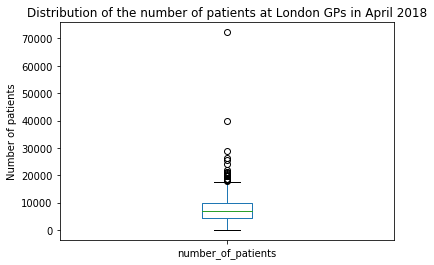

In [189]:
London_gps.plot(kind ='box')
plt.ylabel('Number of patients')
plt.title('Distribution of the number of patients at London GPs in April 2018')

In [190]:
London_gps.number_of_patients.describe()

count     1051.000000
mean      7587.575642
std       4702.761623
min          8.000000
25%       4464.500000
50%       6809.000000
75%       9784.000000
max      72227.000000
Name: number_of_patients, dtype: float64

#### From summary stats and box plot, the number of GPs identified in London is 1051 and the median number of patients at each london GP is 6809. There is a minimum of 8 in the data which likely indicates missing or incomplete data. There is also an outlier with more than 70,000 patients and other with more than 40,000 patients. These may also be errors and will be noted be taken in to consideration when reporting results.

In [191]:
London_gps.number_of_patients.sum() #calculate total number of patients at London GPs.

7974542

#### The total number of patients registered in April 2018 is approximately 7,974,542 million.

In [192]:
alllondon['items'].sum() # calculate the number of prescriptions

8266832.0

#### The total number of prescriptions in April 2018 is 8,266,832 million.

In [193]:
alllondon['act_cost'].sum()  # calculate the cost of the prescriptions

60310390.94999997

#### The total actual cost of these prescriptions is in April 2018 is £60,310,391.

In [194]:
londonbydrug = alllondon[['bnf_name', 'items']] #dataframe with bnf_name and number of prescriptions for london GPs.

In [195]:
londonbydrug = londonbydrug.set_index(['bnf_name'])

In [196]:
grouped = londonbydrug.groupby(level=0).sum()

In [197]:
grouped_sorted = grouped.sort_values('items', axis =0, ascending = False, kind='quicksort', na_position='last')

In [198]:
grouped_sorted.head(10)

,items
bnf_name,
Omeprazole_Cap E/C 20mg,185471.0
Metformin HCl_Tab 500mg,170966.0
Amlodipine_Tab 5mg,155690.0
Atorvastatin_Tab 20mg,146688.0
Aspirin Disper_Tab 75mg,133042.0
Amlodipine_Tab 10mg,126143.0
Atorvastatin_Tab 40mg,125431.0
Lansoprazole_Cap 30mg (E/C Gran),120217.0
Salbutamol_Inha 100mcg (200 D) CFF,109549.0


#### The top 10 most frequent drugs prescribed at London GPs are Omeprazole_Cap E/C 20mg, Metformin HCl_Tab 500mg, Amlodipine_Tab 5mg, Atorvastatin_Tab 20mg, Aspirin Disper_Tab 75mg, Amlodipine_Tab 10mg, Atorvastatin_Tab 40mg, Lansoprazole_Cap 30mg (E/C Gran), Salbutamol_Inha 100mcg (200 D) CFF, Paracet_Tab 500mg

In [199]:
grouped_sorted.tail(200)

,items
bnf_name,
Milupa_Aptamil Follow On Milk,1.0
Milupa_PKU 3 Advanta Pdr,1.0
Mini-Plasco_Lido HCl 2% 10ml Amp,1.0
Methotrexate_Liq Spec 2.5mg/5ml,1.0
Methotrexate_Inj 10mg/0.4ml PF Pen,1.0
Minims_Proxymetacaine HCl 0.5% Ud P/F,1.0
Menopur_Inj 1 200u Vl + Dil,1.0
Melatonin_Cap 2.5mg,1.0
Melgisorb 10cm x 20cm Wound Dress Algin,1.0


#### There are a number of prescriptions with only one unit each (see above table) even when the bottom 200 are selected. Listed last in the table are varicase Class 2 Thigh Open Toe Slc Band, MagnaPhos_Cap 48.6mg (2mmol), Mag Sulf_Inj 50% 2ml Amp, Mag Ox_Cap 100mg, Mag Ox Heavy_Cap 100mg, Macrogol 4000_Pdr Sach 10g S/F, MacGregor_Qufora Leg Bag Straps Ltx Free, MacGregor_Qufora Leg Bag 750ml Direct In, MSUD Cooler_20 Liq, MSUD AID 111_Code 636-1 Pdr.

### Overall comments for Question 1

1) Number of patients registered: Almost 8 million patients were identified in London as being registered with a GP. The ONS estimates that the population of London is approximatly 8,674,000 million people (https://www.ons.gov.uk/aboutus/transparencyandgovernance/freedomofinformationfoi/londonandukpopulation). This would mean that from the above analysis almost 92% of the London is registered with their GP. NHS Digital estimates that just over 10 million people are registed with a GP in the London area in January 2019 (https://app.powerbi.com/view?r=eyJrIjoiNjQxMTI5NTEtYzlkNi00MzljLWE0OGItNGVjM2QwNjAzZGQ0IiwidCI6IjUwZjYwNzFmLWJiZmUtNDAxYS04ODAzLTY3Mzc0OGU2MjllMiIsImMiOjh9).This means that that analysis above has identified about 80% of registered patients. This could be due to missing data and also the method to subset may not be sensitive enough to pick up all available London data. Another method could be attempted as a sensitivity analyis by utilising matching on post-codes for example. Imputing for missing or suspicious looking data is also possible and could be included in sensitivity analyses.

2) When comparing the most frequently prescribed drugs in London with those reported in England in 2017 the results are similar with slightly different rankings (see:https://digital.nhs.uk/data-and-information/publications/statistical/prescription-cost-analysis). There is wide variation England in terms of health linked to different populations, demographics and socioeconomic statuts and so some difference in prescribing patterns is expected. 
England top prescriptions 2017:
*Atorvastatin*
Levothyroxine Sodium
*Omeprazole*
Ramipril
*Amlodipine*
Simvastatin
*Aspirin*
Lansoprazole
Colecalciferol
Bisoprolol Fumarate

## Question 2 

In [200]:
cambridgedata = allcombined[allcombined['city']=='CAMBRIDGE'].copy(deep=True) #dataframe with Cambridge GPs identified using the'city' column

#### Upon inspection of the raw data it's possible to identify Cambridge GPs using the city column. The area column includes Cambridgeshire a wider area than required for this question.


In [201]:
cambridgedata.shape

(38542, 14)

In [202]:
cambridgedata.drop_duplicates(keep='first', inplace=True) #drop duplicates

In [203]:
cambridgedata.shape 

(38542, 14)

In [204]:
cam_gps = cambridgedata[['practice_name','number_of_patients']].drop_duplicates() #dataframe with number of patients in each GP in Cambridge

In [205]:
cam_gps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 4113304 to 4251655
Data columns (total 2 columns):
practice_name         30 non-null object
number_of_patients    30 non-null int64
dtypes: int64(1), object(1)
memory usage: 720.0+ bytes


In [206]:
cam_gps.describe()

,number_of_patients
count,30.000000
mean,10029.500000
std,6382.131164
min,568.000000
25%,6054.250000
50%,8760.500000
75%,12230.250000
max,33501.000000


Text(0.5,1,'Distribution of the number of patients at Cambridge GPs in April 2018')

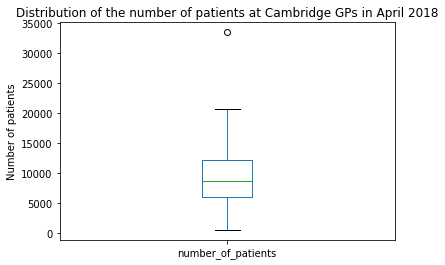

In [207]:
cam_gps.plot(kind='box')
plt.ylabel('Number of patients')
plt.title('Distribution of the number of patients at Cambridge GPs in April 2018')

#### The analysis shows that there are 30 GPs in Cambridge city that have been identified. Each GP has a median of 8,760 patients registered. There is one outlier with just under 35000 patients which may be a recording error. The median number of patients per GP is higher in Cambridge than in London (6,809). It's possible that GP surgeries in Cambridge also include patients living in the surrounding shires with less resources.

In [208]:
cam_gps.number_of_patients.sum() #calculate number of patients at GPs in Cambridge 

300885

#### The total number of patients registered with a GP in Cambridge is 300,885 in April 2018.

In [209]:
cambridgedata['items'].sum() #calculate total number of prescriptions at GPs in Cambridge

330501.0

#### The total number of prescriptions issued in Cambridge in April 2018 is 330,501 thousand

In [210]:
cambridgedata['act_cost'].sum() #calculate total cost of prescriptions at GPs in Cambridge

2338614.11

#### The total actual cost of these prescriptions is in April 2018 is £1,798,702 million.

In [211]:
cambridgebydrug = cambridgedata[['bnf_name', 'items']] #dataframe with bnf name and number of prescriptions

In [212]:
cambridgebydrug = cambridgebydrug.set_index(['bnf_name'])

In [213]:
cambridgebydrug = cambridgebydrug.groupby(level=0).sum()

In [214]:
cambridgebydrug_sorted = cambridgebydrug.sort_values('items', axis =0, ascending = False, kind='quicksort', na_position='last')

In [215]:
cambridgebydrug_sorted.head(10)

,items
bnf_name,
Omeprazole_Cap E/C 20mg,11257.0
Atorvastatin_Tab 20mg,6143.0
Aspirin Disper_Tab 75mg,5411.0
Amlodipine_Tab 5mg,5258.0
Paracet_Tab 500mg,4350.0
Salbutamol_Inha 100mcg (200 D) CFF,4115.0
Levothyrox Sod_Tab 100mcg,3776.0
Amitriptyline HCl_Tab 10mg,3692.0
Folic Acid_Tab 5mg,3637.0


#### The top 10 most frequently drugs prescribed at Cambridge GPs are Omeprazole_Cap E/C 20mg, Atorvastatin_Tab 20mg, Aspirin Disper_Tab 75mg, Amlodipine_Tab 10mg, Paracet_Tab 500mg, Salbutamol_Inha 100mcg (200 D) CFF	, Levothyrox Sod_Tab 100mcg	, Levothyrox Sod_Tab 100mcg, Amitriptyline HCl_Tab 10mg, Folic Acid_Tab 5mg, Levothyrox Sod_Tab 25mcg.

In [216]:
cambridgebydrug_sorted.tail(50)

,items
bnf_name,
Orione Hernia Brief Support Gmt Male Siz,1.0
Orbis Nor Saline Sod Chlor 0.9% Nsl Dps,1.0
Oralieve Moisturising Mth Gel 50ml,1.0
Oralieve Moist Mth Spy 50ml,1.0
Opus_NaturCare Deod A/Spy 50ml,1.0
Opus_NaturCare Breeze Deod A/Spy 50ml,1.0
Dexameth_Tab Solb 4mg S/F,1.0
Paliperidone_Inj 150mg/1.5ml Pfs,1.0
Opus_Lift Medical Adh Remover Soln Sach,1.0


#### There are a number of prescriptions with only 1 item issued. Included in bottom 10 are DermaSilk Pyjamas 5-6 Yr(s) Silk Garment, Oxybutynin HCl_Oral Soln 5mg/5ml S/F, Dermacolor_Camouflage Creme, OxyNorm_Inj 10mg/ml 1ml Amp, OxyContin_Tab 5mg M/R, Oxprenolol HCl_Tab 40mg, Dermacolor_Fixing Pdr, Desloratadine_Oral Soln 2.5mg/5ml S/F, DesmoMelt_Oral Lyoph 240mcg, 365 Strips Skin Closure Strips Ster Surg

### Overall comments for Question 2
1) Number of patients registered: Approiximately 301,000 patients were identified as registered at GPs in the City of Cambridge.This appears to be quite a large number considering the population at the last census(2011) was approximatly 124,000 and is now estimated at 130,000 (https://en.wikipedia.org/wiki/Cambridge). As mentioned above however Cambridge is likely to also support nearby surrounding towns. Cambridge also has a number of students who may not be included in population counts. The distribution of the patients in the dataset was also fairly consistent with one outlier.  Data for Cambridge city alone are not avialable from NHS Digital as they are combined with Peterborough CCG (https://app.powerbi.com/view?r=eyJrIjoiNjQxMTI5NTEtYzlkNi00MzljLWE0OGItNGVjM2QwNjAzZGQ0IiwidCI6IjUwZjYwNzFmLWJiZmUtNDAxYS04ODAzLTY3Mzc0OGU2MjllMiIsImMiOjh9). Together this estimates about 980,000 patients registered. Peterborough is larger than Cambridge (2011 census estimated 184,000 people) and so the split in the numbers is reasonable.

2)There is overlap in the most frequent drugs presibed in Cambridge and London with both including Omeprazole_Cap E/C 20mg as the most frequently prescribed. 

## Question 3 

### Drugs related to cardiovascular disease

In [217]:
#to identify cardiovasular drugs by their BNF code, create a pattern match using a regular expression.
code = '0212000AJ' #test code
regex = '^0201|0202|0203|0204|0205|0206|0207|0208|0209|0210|0211|0212|0213\w*' #pattern match for cardiovascular drugs
if re.search(regex, code): print ('code is valid')

code is valid


In [218]:
pattern = re.compile('^0201|0202|0203|0204|0205|0206|0207|0208|0209|0210|0211|0212|0213\w*') #compile pattern

In [219]:
# define a function that matches rows within the bnf_code column with the regular expression pattern for cardiovascular drugs.
#if there is a match the bnf_code will be returned otherwise an empty row will be returned.
def bnf(row,pattern):
    code = row['bnf_code']
    if bool(pattern.match(code)):
        return code
    else:
        return('')

In [220]:
allcombined_cardio = allcombined.dropna(axis =0, subset=['bnf_code']) #remove any NaNs from the 'bnf_code rows to allow for matching'

In [221]:
#apply function (bnf) to match cardio drugs by bnf codes
#Add a column to the dataframe called 'cardio_drugs' with the results of the pattern matching.
allcombined_cardio['cardio_drugs'] = allcombined_cardio.apply(bnf, axis=1, pattern=pattern).copy(deep=True) 

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [222]:
#remove empty rows indicating no match as per function defined
allcombined_cardio = allcombined_cardio[allcombined_cardio['cardio_drugs'] != ''] 

In [223]:
#select only required columns for analysis
cardio_cost = allcombined_cardio[['act_cost', 'cardio_drugs', 'items', 'bnf_name','practice_organization','practice_code']].drop_duplicates()

In [224]:
Total_items_cardio = cardio_cost['items'].sum() #calculate the number of prescriptions related to cardivascular drugs

print('the total number of prescriptions for drugs related to CVD disease is',Total_items_cardio)

the total number of prescriptions for drugs related to CVD disease is 26403449.0


In [225]:
Total_cost_cardio = cardio_cost['act_cost'].sum().round(2) #calculate the total cost of these prescriptions and round to 2 decimal points
print('the total cost for drugs related to CVD disease is',Total_cost_cardio)

the total cost for drugs related to CVD disease is 89968230.49


### Antidepressants

In [226]:
#to identify antidepressants by their BNF code, create a pattern match using a regular expression.
code2 = '0403030E0' #test code
regex2 = '^0403\w*' #pattern match for antidepressant drugs
if re.search(regex2, code2): print ('code is valid')

code is valid


In [227]:
pattern = re.compile('^0403\w*') #compile regular expression

In [228]:
def ad (row,pattern):
    code = row['bnf_code']
    if bool(pattern.match(code)):
        return code
    else:
        return('')

In [229]:
allcombined_ad = allcombined.dropna(axis =0, subset=['bnf_code']) #drop any NaNs to allow for matching.

In [230]:
#apply ad function to dataframe to match for antidepressants by BNF code. Add a column to the dataframe called 'antidepresants' with the results of the pattern matching.
allcombined_ad['antidepressants'] = allcombined_ad.apply(ad, axis=1, pattern=pattern).copy(deep=True)

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [231]:
allcombined_ad = allcombined_ad[allcombined_ad['antidepressants'] != ''] #remove any empty rows indicating no match

In [232]:
#select columns required for analysis and drop any duplicates
ad_cost = allcombined_ad[['act_cost', 'antidepressants', 'items', 'bnf_name', 'practice_organization','practice_code']].drop_duplicates()

In [233]:
Total_items_ad = ad_cost['items'].sum()
print('the total number of prescriptions for antidepressants is',Total_items_ad)

the total number of prescriptions for antidepressants is 5698725.0


In [234]:
Total_cost_ad = ad_cost['act_cost'].sum().round(2)
print('the total cost for for antidepressants',Total_cost_ad)

the total cost for for antidepressants 16810041.84


### Overall comments on Question 3

    1. Drugs related to cardiovascular disease. The analysis shows that in April 2018 there were 26,403,449 million prescriptions in England issued for drugs related to cardiovascular disease (BNF chapter 2). These prescriptions resulted in approximaltly £90 million pounds in spending. Data reported on open prescribing (https://openprescribing.net/bnf/02/) report similar values i.e. 26,449,832 prescriptions and £90,193,358 million pounds in spending.
    2. Antidepressants. The analysis showes that in April 2018 there were 5,698,725 million prescriptions in England issued for antidepressant drugs (BNF chapter 4.3), resulting in approximaltly £16,810,041 million pounds in spending. Data reported on open prescribing are simliar i.e. 5,715,847 prescriptions issued for antidepressants in April 2018 resulting in £16,853,578 million pounds in spending (https://openprescribing.net/bnf/0403/.

## Question 4

In [235]:
#remove columns not required for this analysis
total_spending = allcombined.drop(['practice_name','practice_organization', 'street', 'city','area','postcode_y','bnf_code', 'bnf_name', 'items', 'nic','quantity',], axis=1)

In [236]:
#group data by practice code and use a lambda function to calculate the total cost per practice
grouped = pd.DataFrame(total_spending.groupby(total_spending.practice_code).apply(lambda x: x['act_cost'].sum()))

In [237]:
grouped.columns = ['total_costs_per_practice'] # rename the column with total act_cost per practice
grouped.reset_index(inplace=True) # Reset the index
grouped.head()

,practice_code,total_costs_per_practice
0,A81001,52194.63
1,A81002,268607.26
2,A81004,139115.40
3,A81005,102914.06
4,A81006,183226.79


In [238]:
#load dataframe of patients registered per practice and remove any white spaces in the column labels
gp_counts = pd.read_csv('gp-reg-pat-prac-all.csv').rename(columns=lambda x: x.strip()) 

(0, 40000)

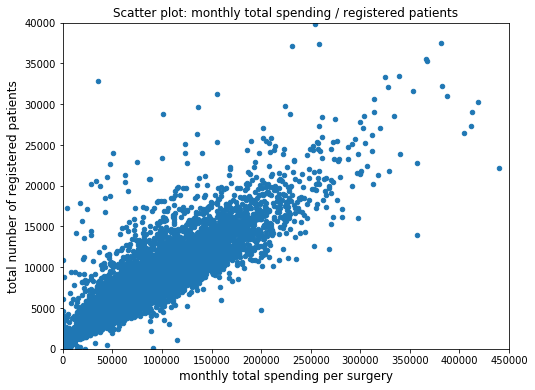

In [239]:
#create scatter plot. First merge grouped dataframe with gp_counts to on practice code so that number of patients in each practice is included for the plot.
merged = pd.merge(grouped, gp_counts[['CODE', 'NUMBER_OF_PATIENTS']], left_on='practice_code' , right_on='CODE')
ax3=merged.plot(kind='scatter', x='total_costs_per_practice', y='NUMBER_OF_PATIENTS', title='Scatter plot: monthly total spending / registered patients', figsize=(8,6))
ax3.set_xlabel("monthly total spending per surgery",fontsize=12)
ax3.set_ylabel("total number of registered patients",fontsize=12)
ax3.set_xlim(0, 450000)
ax3.set_ylim(0, 40000)

#### The scatter plot shows that there is a strong positive assosciation between the monthly total spending per GP surgery and the total number of registerd patients.

LinregressResult(slope=0.0767117741181154, intercept=1461.4699857604437, rvalue=0.8784845183859744, pvalue=0.0, stderr=0.0004903523291872632)

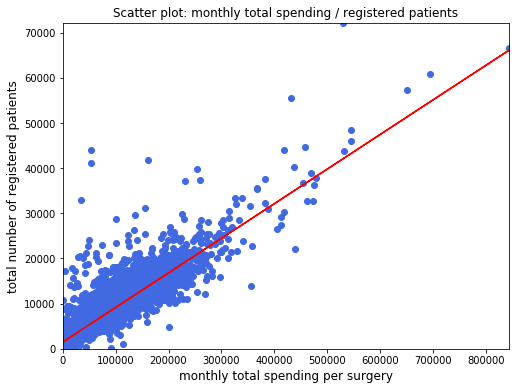

In [240]:
#add regression line to scatter plot as a subplot.
fig=plt.figure(figsize=(8, 6))
ax=fig.add_subplot(111)
x= merged['total_costs_per_practice']
y = merged['NUMBER_OF_PATIENTS']
ax.scatter(x, y, color='royalblue')
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title('Scatter plot: monthly total spending / registered patients')
ax.set_xlabel("monthly total spending per surgery",fontsize=12)
ax.set_ylabel("total number of registered patients",fontsize=12)
max_x = np.floor(merged.total_costs_per_practice.max())
max_y = np.floor(merged.NUMBER_OF_PATIENTS.max())
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)
sp.stats.linregress(x,y)

#### Fitting a regression line shows the strong, positive liner relationship described above. The linear regression results also confirm this. There is a strong correlation (r= 0.878) with a p val ~0 meaning the null hypothesis that the slope is zero can be rejected.  The standard error of the estimated gradient is low  showing that most points fall on the line.

In [241]:
cost_patient_plot = merged
#calculate the cost per patients registerd at a GP
cost_patient_plot['cost_per_patient'] = cost_patient_plot['total_costs_per_practice'] / cost_patient_plot['NUMBER_OF_PATIENTS'] 

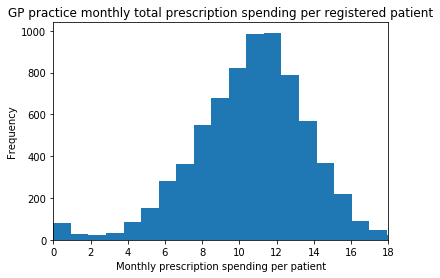

In [242]:
#plot a histogram to visualise the distribution of monthly spending per patient.
x = cost_patient_plot.cost_per_patient.values

plt.hist(x, bins=3000)

plt.xlabel("Monthly prescription spending per patient")
plt.ylabel("Frequency")

min_x = np.floor(cost_patient_plot['cost_per_patient'].quantile(.01))
max_x = np.floor(cost_patient_plot['cost_per_patient'].quantile(.99))
plt.xlim(min_x, max_x) #do not show outliers
plt.title("GP practice monthly total prescription spending per registered patient")
plt.show()

#### The peaks of the histogram show that most GPs monthly prescription spending per patients is £10-£12 pounds. The histogram suggests a normal distrobution with a slight right skew. There are some outliers which may suggest incorrect or missing data particularly on the left side of the histogram.

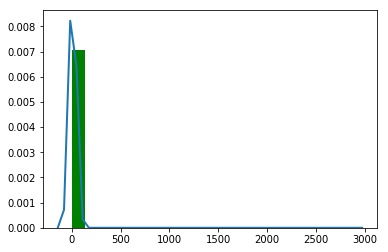

NormaltestResult(statistic=11.8114072305789, pvalue=0.0027238645535719026)

In [243]:
#fit normal distribution to the histogram
x = cost_patient_plot.cost_per_patient.values
mu, std = norm.fit(x)
plt.hist(x, bins=20, density=True, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)
p = norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2)
plt.show()
sp.stats.normaltest(x)

#### The Gaussian curve suggests a normal distribution with a slight left skew as described above. this is confirmed by conducting a normal test on the sample. The pvalue is less than 0.05 and so we can reject the null hypothesis and assume a normal distribution.

# Assignment B
Data used in this section are available at: https://www.who.int/healthinfo/statistics/mortality_rawdata/en/

In [244]:
#load WHO mortality data csv file (1 of 2) as a pandas DataFrame and remove any white space in column names using lamdda function
mortality1=pd.read_csv('Morticd10_part1.csv', sep=',', index_col=False, low_memory=False).rename(columns=lambda x: x.strip())

In [245]:
#load WHO mortality data csv file (2 of 2) as a pandas DataFrame and remove any white space in column names using lamdda function
mortality2=pd.read_csv('Morticd10_part2.csv', sep=',', index_col=False, low_memory=False).rename(columns=lambda x: x.strip())

In [246]:
combined_mortality = pd.concat([mortality1,mortality2], ignore_index=True) #combine the two WHO mortality dataframes

In [247]:
del mortality1 #delete

In [248]:
del mortality2 #delete

In [249]:
#Explore data using different methods: info, head, tail, describe, dytpes

In [250]:
combined_mortality.info(null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704896 entries, 0 to 3704895
Data columns (total 39 columns):
Country       3704896 non-null int64
Admin1        84173 non-null float64
SubDiv        2707 non-null object
Year          3704896 non-null int64
List          3704896 non-null object
Cause         3704896 non-null object
Sex           3704896 non-null int64
Frmat         3704896 non-null int64
IM_Frmat      3704896 non-null int64
Deaths1       3704896 non-null int64
Deaths2       3702654 non-null float64
Deaths3       3702654 non-null float64
Deaths4       3537648 non-null float64
Deaths5       3537648 non-null float64
Deaths6       3537648 non-null float64
Deaths7       3702654 non-null float64
Deaths8       3699669 non-null float64
Deaths9       3702654 non-null float64
Deaths10      3699669 non-null float64
Deaths11      3702654 non-null float64
Deaths12      3699669 non-null float64
Deaths13      3702654 non-null float64
Deaths14      3699669 non-null float64
Deaths15  

#### There are 3,704,896 records as per WHO documentation in the dataframe which is aligned with the WHO documentation for this data. There are null values in columns for deaths. This may mean zero deaths (not entered as such) or actual missing data. 

In [251]:
combined_mortality.tail() #to inspect the last five rows of the dataframe

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
3704891,4070,NaN,NaN,2015,103,Y85,1,2,1,14,...,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3704892,4070,NaN,NaN,2015,103,Y85,2,2,1,3,...,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3704893,4070,NaN,NaN,2015,103,Y86,1,2,1,37,...,2.0,5.0,4.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3704894,4070,NaN,NaN,2015,103,Y86,2,2,1,16,...,4.0,1.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3704895,4070,NaN,NaN,2015,103,Y87,1,2,1,5,...,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [252]:
combined_mortality.columns #inspect column names for inconsistencies, for example white spaces or typographical errors and if the data type is appropriate

Index(['Country', 'Admin1', 'SubDiv', 'Year', 'List', 'Cause', 'Sex', 'Frmat',
       'IM_Frmat', 'Deaths1', 'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5',
       'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11',
       'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17',
       'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23',
       'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2',
       'IM_Deaths3', 'IM_Deaths4'],
      dtype='object')

In [253]:
#exploratory summary stats to identify outliers or columns needing further investigation, only being reviewed for deaths columns. This exlcudes NaN.
combined_mortality.describe() 

,Country,Admin1,Year,Sex,Frmat,IM_Frmat,Deaths1,Deaths2,Deaths3,Deaths4,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
count,3.704896e+06,84173.000000,3.704896e+06,3.704896e+06,3.704896e+06,3.704896e+06,3.704896e+06,3.702654e+06,3.702654e+06,3.537648e+06,...,3.702330e+06,3.691478e+06,3.691478e+06,3.220900e+06,3.220900e+06,3.702654e+06,3.702653e+06,2.863458e+06,2.952678e+06,2.952678e+06
mean,3.241099e+03,901.553610,2.006715e+03,1.511633e+00,1.886407e-01,2.445921e+00,1.858943e+02,3.882018e+00,5.248063e-01,2.075379e-01,...,2.337166e+01,2.474446e+01,2.411793e+01,1.310711e+01,5.837956e+00,3.619177e-01,2.412954e+00,5.529056e-01,3.709731e-01,9.350325e-01
std,1.012568e+03,0.497121,5.630995e+00,7.269989e-01,5.820991e-01,2.809113e+00,6.876699e+03,1.619323e+02,2.501903e+01,8.472934e+00,...,9.170278e+02,9.820946e+02,1.023807e+03,6.331996e+02,3.267359e+02,2.903795e+01,1.320457e+02,2.591263e+01,1.771219e+01,5.068250e+01
min,1.060000e+03,901.000000,1.988000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.240000e+03,901.000000,2.002000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.320000e+03,902.000000,2.007000e+03,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.188000e+03,902.000000,2.012000e+03,2.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.150000e+03,902.000000,2.017000e+03,9.000000e+00,9.000000e+00,9.000000e+00,1.400232e+06,4.209700e+04,8.147000e+03,1.802000e+03,...,2.075960e+05,2.097350e+05,2.362490e+05,2.011200e+05,1.172570e+05,1.429500e+04,4.209700e+04,9.476000e+03,5.786000e+03,1.765400e+04


#### There are some outliers identified for infant mortality (IM_Deaths) in the max rows. These would need further investigation if data were to be used.

In [254]:
combined_mortality[['Sex']] = combined_mortality[['Sex']].astype('category') #change dtype of 'Sex' column from int to category

In [255]:
combined_mortality['Cause'] = combined_mortality['Cause'].str.strip() #remove any white spaces

In [256]:
#read in WHO population data frame as pandas data frame and remove any white spaces from column names
population = pd.read_csv('pop.csv', sep=',', index_col=False).rename(columns=lambda x: x.strip())

In [257]:
#Explore data using different methods: info, head, tail, describe, dytpes
population.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9383 entries, 0 to 9382
Data columns (total 33 columns):
Country    9383 non-null int64
Admin1     82 non-null float64
SubDiv     138 non-null object
Year       9383 non-null int64
Sex        9383 non-null int64
Frmat      9383 non-null int64
Pop1       9383 non-null float64
Pop2       9247 non-null float64
Pop3       9247 non-null float64
Pop4       5178 non-null float64
Pop5       5178 non-null float64
Pop6       5178 non-null float64
Pop7       9247 non-null float64
Pop8       9229 non-null float64
Pop9       9247 non-null float64
Pop10      9229 non-null float64
Pop11      9247 non-null float64
Pop12      9229 non-null float64
Pop13      9247 non-null float64
Pop14      9229 non-null float64
Pop15      9247 non-null float64
Pop16      9229 non-null float64
Pop17      9247 non-null float64
Pop18      9229 non-null float64
Pop19      9247 non-null float64
Pop20      9185 non-null float64
Pop21      9091 non-null float64
Pop22      822

#### There are 9383 rows in the frame and non-null counts for the population columns indicate that there are some missing data. This will be taken into account for reporting.

In [258]:
population.head()

,Country,Admin1,SubDiv,Year,Sex,Frmat,Pop1,Pop2,Pop3,Pop4,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
0,1060,NaN,NaN,1980,1,7,137100.0,3400.0,15800.0,NaN,...,NaN,5300.0,NaN,2900.0,NaN,NaN,NaN,NaN,6500.0,5000.0
1,1060,NaN,NaN,1980,2,7,159000.0,4000.0,18400.0,NaN,...,NaN,6200.0,NaN,3400.0,NaN,NaN,NaN,NaN,7500.0,6000.0
2,1125,NaN,NaN,1955,1,2,5051500.0,150300.0,543400.0,NaN,...,110200.0,51100.0,41600.0,14300.0,11800.0,25300.0,NaN,NaN,0.0,253329.0
3,1125,NaN,NaN,1955,2,2,5049400.0,145200.0,551000.0,NaN,...,122100.0,51100.0,50700.0,15800.0,18000.0,28500.0,NaN,NaN,0.0,237901.0
4,1125,NaN,NaN,1956,1,2,5353700.0,158700.0,576600.0,NaN,...,116900.0,54100.0,44000.0,14900.0,12400.0,26600.0,NaN,NaN,0.0,250022.0


In [259]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9383 entries, 0 to 9382
Data columns (total 33 columns):
Country    9383 non-null int64
Admin1     82 non-null float64
SubDiv     138 non-null object
Year       9383 non-null int64
Sex        9383 non-null int64
Frmat      9383 non-null int64
Pop1       9383 non-null float64
Pop2       9247 non-null float64
Pop3       9247 non-null float64
Pop4       5178 non-null float64
Pop5       5178 non-null float64
Pop6       5178 non-null float64
Pop7       9247 non-null float64
Pop8       9229 non-null float64
Pop9       9247 non-null float64
Pop10      9229 non-null float64
Pop11      9247 non-null float64
Pop12      9229 non-null float64
Pop13      9247 non-null float64
Pop14      9229 non-null float64
Pop15      9247 non-null float64
Pop16      9229 non-null float64
Pop17      9247 non-null float64
Pop18      9229 non-null float64
Pop19      9247 non-null float64
Pop20      9185 non-null float64
Pop21      9091 non-null float64
Pop22      822

In [260]:
#create smaller data frame with population at all ages and delete larger dataframe. This is in Pop1 as per data documentation.

In [261]:
population.columns

Index(['Country', 'Admin1', 'SubDiv', 'Year', 'Sex', 'Frmat', 'Pop1', 'Pop2',
       'Pop3', 'Pop4', 'Pop5', 'Pop6', 'Pop7', 'Pop8', 'Pop9', 'Pop10',
       'Pop11', 'Pop12', 'Pop13', 'Pop14', 'Pop15', 'Pop16', 'Pop17', 'Pop18',
       'Pop19', 'Pop20', 'Pop21', 'Pop22', 'Pop23', 'Pop24', 'Pop25', 'Pop26',
       'Lb'],
      dtype='object')

In [262]:
#create smaller data frame with population column containing data for 'all ages' (Pop1 as per data documentation).
pop_all_ages = population.drop(['Pop2',
       'Pop3', 'Pop4', 'Pop5', 'Pop6', 'Pop7', 'Pop8', 'Pop9', 'Pop10',
       'Pop11', 'Pop12', 'Pop13', 'Pop14', 'Pop15', 'Pop16', 'Pop17', 'Pop18',
       'Pop19', 'Pop20', 'Pop21', 'Pop22', 'Pop23', 'Pop24', 'Pop25', 'Pop26',
       'Lb'], axis =1)

In [263]:
pop_all_ages['Pop1'] = pop_all_ages['Pop1'].astype('int64') #change Pop1 dtype from float to integer

In [264]:
pop_all_ages.Pop1.dtype

dtype('int64')

In [265]:
#data frame with population columns containing data for 'all ages' (Pop2 to Pop26 as per WHO data documentation).
pop_by_age = population.drop(['Admin1', 'SubDiv', 'Sex', 'Frmat', 'Pop1',
       'Lb'],axis=1)

In [266]:
del population

## Question 1

    1) Iceland - country code 4160
    2) Italy - 4180
    3) New Zealand -5150
    4) Australia - 5020

Country codes are available in Table 11 of the documentation supplied with these data and available here: https://www.who.int/healthinfo/statistics/documentation.zip?ua=1

In [267]:
# create seperate dataframes for each country.Filter by the appropriate country codes.
Iceland = combined_mortality[combined_mortality['Country']==4160]

In [268]:
Italy = combined_mortality[combined_mortality['Country']==4180]

In [269]:
NZealand = combined_mortality[combined_mortality['Country']==5150]

In [270]:
Australia = combined_mortality[combined_mortality['Country']==5020]

### Iceland population and mortality rate in 2010


In [271]:
Iceland_pop_all_ages = pop_all_ages[pop_all_ages['Country']==4160] # create dataframe with Iceland population only

In [272]:
print(Iceland_pop_all_ages[Iceland_pop_all_ages['Year'] ==2010]['Pop1']) # select year 2010 and population at all ages

5951    159971
5952    158070
Name: Pop1, dtype: int64


In [273]:
#Iceland population in 2010 is  159971 males and 158070 females
Ipop = 159971 + 158070
print('The population in Iceland in 2010 was',Ipop)

The population in Iceland in 2010 was 318041


In [274]:
Iceland_all = Iceland[Iceland['Cause'] == 'AAA'] #dataframe with total deaths from all causes (code is AAA as per WHO documentation)

In [275]:
print(Iceland_all[Iceland_all['Year'] == 2010]['Deaths1']) #select deaths in 2010, Deaths1 includes deaths at all ages

1536883    1064
1536884     955
Name: Deaths1, dtype: int64


In [276]:
#Iceland total number of deaths (from all causes, all ages) in 2010 is 1064 males and  955 females
Ideaths = 1064 + 955
print('The total number of deaths (from all causes, all ages) in 2010 in Iceland was', Ideaths)
#deaths validated by WHO

The total number of deaths (from all causes, all ages) in 2010 in Iceland was 2019


In [277]:
Imortality_rate = Ideaths/Ipop*100 #calculate the mortality rate
print('The mortality rate(%) for Iceland in 2010 was' ,Imortality_rate,'%')

The mortality rate(%) for Iceland in 2010 was 0.6348238120242359 %



### Italy population and mortality rate in 2010

In [278]:
Italy_pop_all_ages = pop_all_ages[pop_all_ages['Country']==4180] #dataframe with Italy population

In [279]:
print(Italy_pop_all_ages[Italy_pop_all_ages['Year'] ==2010]['Pop1']) # select year 2010 and population at all ages

6213    29350339
6214    31133047
Name: Pop1, dtype: int64


In [280]:
#Italy population in 2010 is 29350339 males and 31133047 females
Itpop = 29350339 + 31133047
print('The population in Italy in 2010 was',Itpop)

The population in Italy in 2010 was 60483386


In [281]:
Italy_allcause = Italy[Italy['Cause'] == 'AAA'] #df with deaths from all causes in Italy identified by code AAA

In [282]:
print(Italy_allcause[Italy_allcause['Year'] == 2010]['Deaths1']) #select deaths in 2010 for all ages

3063601    285068
3063602    299547
Name: Deaths1, dtype: int64


In [283]:
#Italy total number of deaths (from all causes, all ages) in 2010 is 285068 males and 299547 females
Itdeaths = 285068 + 299547
print('The total number of deaths (from all causes, all ages) in 2010 in Italy was', Ideaths)
#deaths validated by WHO

The total number of deaths (from all causes, all ages) in 2010 in Italy was 2019


In [284]:
Imortality_rate = Itdeaths/Itpop*100 #calculate the mortality rate
print('The mortality rate(%) for Italy in 2010 was' ,Imortality_rate,'%')

The mortality rate(%) for Italy in 2010 was 0.9665712167635587 %


### New Zealand population and mortality rate in 2010

In [285]:
NZealand_pop_all_ages = pop_all_ages[pop_all_ages['Country']==5150] #dataframe with New Zealand population; country code is 5150.

In [286]:
print(NZealand_pop_all_ages[NZealand_pop_all_ages['Year'] ==2010]['Pop1']) # select year 2010 and population at all ages

9369    2144390
9370    2222970
Name: Pop1, dtype: int64


In [287]:
#New Zealand population in 2010 is 2144390 males and 2222970 females
Npop = 2144390 + 2222970
print('The population in New Zealand in 2010 was',Npop)

The population in New Zealand in 2010 was 4367360


In [288]:
NZealand_allcause = NZealand[NZealand['Cause'] == 'AAA'] # deaths from all causes

In [289]:
print(NZealand_allcause[NZealand_allcause['Year'] == 2010]['Deaths1']) #select deaths in 2010 for all ages

3682534    14344
3682535    14305
Name: Deaths1, dtype: int64


In [290]:
#New Zealand total number of deaths (from all causes, all ages) in 2010 is 14344 males and 14305 females
Ndeaths =  14344 + 14305
print('The total number of deaths (from all causes, all ages) in 2010 in New Zealand was', Ndeaths)
#deaths validated by WHO

The total number of deaths (from all causes, all ages) in 2010 in New Zealand was 28649


In [291]:
Imortality_rate = Ndeaths/Npop*100 #calculate the mortality rate
print('The mortality rate(%) for New Zealand in 2010 was' ,Imortality_rate,'%')

The mortality rate(%) for New Zealand in 2010 was 0.6559798138921453 %


### Overall comments on question 1

In 2010, Italy had the highest population (just over 60 million people) and also had the highest mortality rate (almost 1%) as compared to Iceland and New Zealand.
These results can be validated at the WHO online mortality database:http://apps.who.int/healthinfo/statistics/mortality/whodpms/

## Question 2 

In [292]:
Italy_allcause.columns

Index(['Country', 'Admin1', 'SubDiv', 'Year', 'List', 'Cause', 'Sex', 'Frmat',
       'IM_Frmat', 'Deaths1', 'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5',
       'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11',
       'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17',
       'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23',
       'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2',
       'IM_Deaths3', 'IM_Deaths4'],
      dtype='object')

In [293]:
#For analysis exlude IM deaths as these are included in deaths2 column. Exclude deaths at age (Death 26) unspecified causes of death
Italy_distribution = Italy_allcause.drop(['Country', 'Admin1', 'SubDiv', 'Year', 'List', 'Cause', 'Sex', 'Frmat',
       'IM_Frmat', 'Deaths1','IM_Deaths1', 'IM_Deaths2',
       'IM_Deaths3', 'IM_Deaths4','Deaths26'], axis=1).loc[:,:].sum() 

Text(0,0.5,'Number of deaths (all causes, all years)')

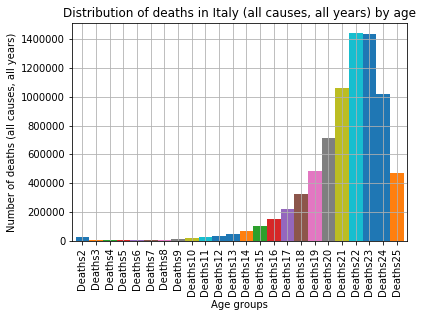

In [294]:
#plot distribution of deaths by age category and frequency calculated.
Italy_distribution.plot(kind='bar', x =Italy_distribution.index, y=Italy_distribution.values,grid=True, title ='Distribution of deaths in Italy (all causes, all years) by age',
logx=False, width=1, legend = False)
plt.xlabel('Age groups')
plt.ylabel('Number of deaths (all causes, all years)')

In [295]:
sp.stats.normaltest(Italy_distribution)

NormaltestResult(statistic=9.921267660562451, pvalue=0.007008484234957212)

### Comments on Question 2
 The key for the age groups is shown below. The graph shows that Deaths22 (age 80-84 years) and Deaths23 (age 85-89 years) occur at the highest frequency (over 1.4 million) when considering all causes, over all years available. Mortality increases as age increases. The distribution is suggests normal with a right skew. This is confirmed by normal test conducted on the data as p<0.05 we can reject the null hypothesis and conclude that sample comes from a normal distribution.


    -Deaths1	Deaths at all ages
    -Deaths2	Deaths at age 0 year
    -Deaths3	Deaths at age 1 year
    -Deaths4	Deaths at age 2 years
    -Deaths5	Deaths at age 3 years
    -Deaths6	Deaths at age 4 years
    -Deaths7	Deaths at age 5-9 years
    -Deaths8	Deaths at age 10-14 years
    -Deaths9	Deaths at age 15-19 years
    -Deaths10 Deaths at age 20-24 years
    -Deaths11 Deaths at age 25-29 years
    -Deaths12 Deaths at age 30-34 years
    -Deaths13 Deaths at age 35-39 years
    -Deaths14 Deaths at age 40-44 years
    -Deaths15 Deaths at age 45-49 years
    -Deaths16 Deaths at age 50-54 years
    -Deaths17 Deaths at age 55-59 years
    -Deaths18 Deaths at age 60-64 years
    -Deaths19 Deaths at age 65-69 years
    -Deaths20 Deaths at age 70-74 years
    -Deaths21 Deaths at age 75-79 years
    -Deaths22 Deaths at age 80-84 years
    -Deaths23 Deaths at age 85-89 years
    -Deaths24 Deaths at age 90-94 years
    -Deaths25 Deaths at age 95 years and above 

## Question 3

In [296]:
#pattern to identify ICD-10 codes for neoplasms (ICD-Codes: C00-D48)
icdRegex ='^C\d{2}$|C\d{2}\.\d{1}$|C\d{2}\.\d{1,2}$|C\d{2}\.\d{3}$|D[0][0]$|[D][0][1-9]$|[D][1][0-9]$|[D][2][0-9]$|[D][3][0-9]$|[D][4][0-8]$' 

In [297]:
code2 ='C22.9' #check pattern recognition for neoplasm ICD-code
if re.match(icdRegex, code2): print ('ICD-10 neoplasms code is valid')
else: print ('ICD-10 neoplasms code ', code2,' is invalid')

ICD-10 neoplasms code is valid


In [298]:
#compliLe pattern
pattern = re.compile('^C\d{2}$|C\d{2}\.\d{1}$|C\d{2}\.\d{1,2}$|C\d{2}\.\d{3}$|D[0][0]$|[D][0][1-9]$|[D][1][0-9]$|[D][2][0-9]$|[D][3][0-9]$|[D][4][0-8]$')

In [299]:
#define function, neo, that will match the regular expression with the ICD code in the 'Cause' column across all rows. 
#If there is a match the code will be returned, othewise a blank space will be returned.
def neo(row,pattern):
    code = row['Cause']
    if bool(pattern.match(code)):
        return code
    else:
        return('')

In [300]:
#apply function,neo, to match ICD10 neoplasms as cause of death in column 'Cause' and add a new column 'neoplasms' to the dataframe with these data.
Italy['neoplasms'] = Italy.apply(neo, axis=1,pattern=pattern).copy(deep=True) 
#apply function to match ICD10 neoplasms as cause of death in column 'Cause' and add a new column 'neoplasms' to the df with these data.

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [301]:
Italy_neoplasms = Italy[Italy.neoplasms != ''] #remove rows where there was no match with a neoplasms ICD code

In [302]:
Italy_neoplasms.head() #check df

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4,neoplasms
1053602,4180,NaN,NaN,2003,104,C01,1,0,1,91,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C01
1053603,4180,NaN,NaN,2003,104,C01,2,0,1,16,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,C01
1053632,4180,NaN,NaN,2003,104,C07,1,0,1,124,...,19.0,15.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,C07
1053633,4180,NaN,NaN,2003,104,C07,2,0,1,82,...,15.0,12.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0,C07
1053651,4180,NaN,NaN,2003,104,C12,1,0,1,44,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C12


In [303]:
Italy_neoplasms = Italy_neoplasms.drop(['Admin1','SubDiv'], axis=1) # remove empty columns

In [304]:
# columns not required for analysis. Deaths1 includes deaths at all ages
Italy_neoplasms_Deaths1 = Italy_neoplasms.drop(['Country', 'List', 'Cause', 'Sex', 'Frmat', 'IM_Frmat', 'Deaths2', 'Year', 'Deaths3', 'Deaths4', 'Deaths5', 'Deaths6',
       'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12',
       'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17', 'Deaths18',
       'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23', 'Deaths24',
       'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2', 'IM_Deaths3',
       'IM_Deaths4'], axis=1) 

In [305]:
Italy_neoplasms_Deaths1 = Italy_neoplasms_Deaths1.set_index('neoplasms') #set neoplasms as index for df

In [306]:
Italy_neoplasms_Deaths1 =Italy_neoplasms_Deaths1.rename(columns = {'Deaths1': 'Total_deaths'}) #rename Deaths1 column

In [307]:
Italy_neoplasms_Deaths1 = Italy_neoplasms_Deaths1.groupby(level=0).sum() #groupby to allow for sorting of data by ICD-code

In [308]:
Italy_neoplasms_Deaths1.sort_values('Total_deaths', axis =0, ascending = False, kind='quicksort', na_position='last')

,Total_deaths
neoplasms,
C61,95906
C64,41962
C20,41199
C56,41196
C80,33186
C55,22585
C97,19922
C23,15763
C19,13323


#### The analysis shows that the top five neoplasms causing death in Italy are the following:

    -C61	Malignant neoplasm of prostate
    -C64	Malignant neoplasm of kidney
    -C20	Malignant neoplasm of colon, rectum and anus
    -C56	Malignant neoplasm of the ovary
    -C80	Malignant neoplasm without specification of site
    -C55	Malignant neoplasm of other and unspecified parts of uterus

#### C80 is recorded without specification of site (could be many different tumours) therefore C55 is included in the top five.

For ICD-code lists see https://www.who.int/classifications/en/ and the documentation provided with the WHO data.

In [309]:
Italy_neoplasms_Deaths1.head()

,Total_deaths
neoplasms,
C01,1359
C07,3214
C12,592
C19,13323
C20,41199


In [310]:
#create column in dataframe with proportion of death per total death due to neoplasms
Italy_neoplasms_Deaths1['Proportion'] = (Italy_neoplasms_Deaths1['Total_deaths']/Italy_neoplasms_Deaths1['Total_deaths'].sum())*100

In [311]:
#sort values
Italy_neoplasms_Deaths1.sort_values('Total_deaths', axis =0, ascending = False, kind='quicksort', na_position='last')

,Total_deaths,Proportion
neoplasms,,
C61,95906,27.916982
C64,41962,12.214589
C20,41199,11.992490
C56,41196,11.991617
C80,33186,9.660010
C55,22585,6.574198
C97,19922,5.799034
C23,15763,4.588403
C19,13323,3.878151


In [312]:
#top5 malignacies resulting in death excluding unspecified i.e. C80
Italy_pie = Italy_neoplasms_Deaths1.loc[['C61','C64','C20','C56','C55']] 

In [313]:
Italy_pie = Italy_pie.reset_index(level=0)

In [314]:
Italy_pie = Italy_pie.rename(columns= {'neoplasms': 'cause of death', 'Total_deaths': 'number of deaths','Proportion' :'proportion of overall deaths'})

In [315]:
print(Italy_pie)

  cause of death  number of deaths  proportion of overall deaths
0            C61             95906                     27.916982
1            C64             41962                     12.214589
2            C20             41199                     11.992490
3            C56             41196                     11.991617
4            C55             22585                      6.574198


In [316]:
#include proportion of remaining neoplasms in dataframe
other_inclu_unspecified = 100-(27.916982 + 12.214589 + 11.992490 + 11.991617 + 6.574198) 
df2 = {'cause of death': 'Other','number of deaths': 'missing','proportion of overall deaths':other_inclu_unspecified}
Italy_pie_new = Italy_pie.append(df2, ignore_index=True)

In [317]:
print(Italy_pie_new)

  cause of death number of deaths  proportion of overall deaths
0            C61            95906                     27.916982
1            C64            41962                     12.214589
2            C20            41199                     11.992490
3            C56            41196                     11.991617
4            C55            22585                      6.574198
5          Other          missing                     29.310124


Text(0.5,1,'Top 5 Neoplasms resulting in death in Italy')

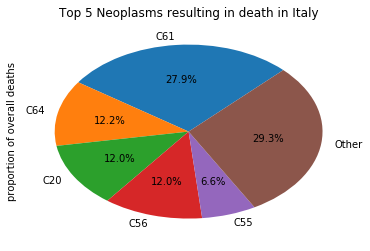

In [318]:
#plot pie chart with top 5 including a slice for 'other'
Italy_pie_new.plot(kind='pie', y ='proportion of overall deaths', x='cause of death', startangle=45, labels=Italy_pie_new['cause of death'], autopct='%1.1f%%', legend=False)
plt.title('Top 5 Neoplasms resulting in death in Italy')

### Comments on question 3

In Italy the leading cause of death due to cancer is prostate cancer, accounting for almost 28% of all cancer deaths across all years and ages. This was followed by kidney cancer (C64), colon cancer (C20), ovarian cancer (C56) and uterine cancer (C55).
Given more time I would investigate these results further as it's a bit suprising that lung cancer has not been identified. If there is an error it could be due to the regular expression defined, missing data or other issues within the dataframe. The results below assume that the analysis is correct.

In [319]:
#apply function,neo, to match ICD10 neoplasms as cause of death in column 'Cause' and add a new column 'neoplasms' to the dataframe with these data.
Australia['neoplasms'] = Australia.apply(neo, axis=1,pattern=pattern)

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [320]:
#remove empty rows indicating no match
Australia_neoplasms = Australia[Australia['neoplasms'] != '']

In [321]:
Australia_neoplasms2010 = Australia_neoplasms[Australia_neoplasms['Year']==2010] #select data in 2010

In [322]:
Australia_neoplasms2010 = Australia_neoplasms.drop(['Country', 'Deaths1','Admin1', 'SubDiv', 'Year', 'List', 'Cause', 'Sex', 'Frmat',
       'IM_Frmat'], axis=1) # columns not needed for analysis

In [323]:
Australia_neoplasms2010.describe()

,Deaths2,Deaths3,Deaths4,Deaths5,Deaths6,Deaths7,Deaths8,Deaths9,Deaths10,Deaths11,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.0,570.0,570.0,570.000000
mean,0.010526,0.008772,0.008772,0.021053,0.008772,0.050877,0.047368,0.084211,0.159649,0.324561,...,43.154386,45.556140,35.084211,16.471930,4.175439,0.008772,0.0,0.0,0.0,0.010526
std,0.102146,0.093329,0.093329,0.155437,0.093329,0.249867,0.220724,0.355617,0.503890,0.849849,...,100.654732,119.849545,99.207191,49.081333,12.275431,0.110568,0.0,0.0,0.0,0.102146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,5.000000,3.000000,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,42.750000,43.000000,29.750000,12.000000,3.000000,0.000000,0.0,0.0,0.0,0.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,4.000000,5.000000,6.000000,...,604.000000,812.000000,725.000000,429.000000,105.000000,2.000000,0.0,0.0,0.0,1.000000


In [324]:
Australia_neoplasms2010 = Australia_neoplasms2010.set_index('neoplasms')

In [325]:
Australia_neoplasms2010.loc['deaths_total']= Australia_neoplasms2010.sum() #add row with total of deaths by age groups

In [326]:
Australia_neoplasms2010.tail()

,Deaths2,Deaths3,Deaths4,Deaths5,Deaths6,Deaths7,Deaths8,Deaths9,Deaths10,Deaths11,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
neoplasms,,,,,,,,,,,,,,,,,,,,,
C73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,13.0,11.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0
D27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
D45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
deaths_total,6.0,5.0,5.0,12.0,5.0,29.0,27.0,48.0,91.0,185.0,...,24598.0,25967.0,19998.0,9389.0,2380.0,5.0,0.0,0.0,0.0,6.0


In [327]:
Australia_neoplasms2010.sort_values('deaths_total', axis =1, ascending = False, kind='quicksort', na_position='last') #sort values

,Deaths22,Deaths21,Deaths23,Deaths20,Deaths19,Deaths18,Deaths24,Deaths17,Deaths16,Deaths15,...,Deaths5,Deaths2,IM_Deaths4,Deaths3,Deaths6,Deaths4,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3
neoplasms,,,,,,,,,,,,,,,,,,,,,
C01,2.0,1.0,0.0,2.0,1.0,4.0,0.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C01,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C07,8.0,5.0,3.0,12.0,4.0,3.0,3.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C07,5.0,4.0,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12,1.0,4.0,1.0,10.0,8.0,3.0,0.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C19,23.0,19.0,6.0,18.0,22.0,16.0,0.0,12.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C19,9.0,21.0,4.0,12.0,11.0,14.0,9.0,6.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C20,77.0,92.0,36.0,90.0,78.0,85.0,15.0,48.0,35.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comments
#### The age groups with the highest rate of mortality also presenting with a neoplasm are Deaths22 (age 80-84 years), Deaths21 (age 75-79 years), Deaths23 (85-89 years), Deaths20 (70-74 years), Deaths19 (65-69 years). This may be due to higher incidence of cancer in older populations or due to the fact that overall mortality rate is higher in older people. The age specific mortality rates below provide some more insights.

## Question 5 


### Top 5 causes of death by neoplasm in Australia compared to Italy

In [328]:
#dataframe with deaths including all ages (Deaths1) for Australia
Australia_neoplasms2010_d1 = Australia_neoplasms.drop(['Admin1', 'SubDiv','List','Sex', 'Frmat', 'IM_Frmat', 'Cause','Deaths2','Deaths3', 'Deaths4', 'Deaths5', 'Deaths6',
       'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12',
       'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17', 'Deaths18',
       'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23', 'Deaths24',
       'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2', 'IM_Deaths3',
       'IM_Deaths4'], axis=1) 

In [329]:
Australia_neoplasms2010_d1 = Australia_neoplasms2010_d1[Australia_neoplasms2010_d1['Year']==2010] #select 2010 data

In [330]:
Australia_neoplasms2010_d1 = Australia_neoplasms2010_d1.drop(['Year'], axis=1) #column not required

In [331]:
#calculate the total number of deaths due to neoplasms in 2010, create a new column to report data
Aus_neoplasms2010_grouped = pd.DataFrame(Australia_neoplasms2010_d1.groupby(Australia_neoplasms2010_d1.neoplasms).apply(lambda x: x['Deaths1'].sum()))

In [332]:
Aus_neoplasms2010_grouped.columns = ['Australia_deaths_2010']
Aus_neoplasms2010_grouped.reset_index(inplace=True)
Aus_neoplasms2010_grouped.head()

,neoplasms,Australia_deaths_2010
0,C01,27
1,C07,71
2,C12,30
3,C19,1127
4,C20,712


In [333]:
#Australia population in 2010 was
Aus_pop_all_ages = pop_all_ages[pop_all_ages['Country']==5020] #dataframe with Iceland population

In [334]:
print(Aus_pop_all_ages[Aus_pop_all_ages['Year'] ==2010]['Pop1']) # select year 2010

9197    11100244
9198    11197271
Name: Pop1, dtype: int64


In [335]:
#Australia population in 2010 is 11100244 males and 11197271 females
Auspop = 11197271 + 11197271
print('The population in Australia in 2010 was',Auspop)

The population in Australia in 2010 was 22394542


In [336]:
#calculate proportion per 100,000 of deaths due to specific cancer type
Aus_neoplasms2010_grouped['Aus_prop_deaths']= (Aus_neoplasms2010_grouped['Australia_deaths_2010']/Auspop)*100000

In [337]:
Aus_neoplasms2010_grouped.head()

,neoplasms,Australia_deaths_2010,Aus_prop_deaths
0,C01,27,0.120565
1,C07,71,0.317042
2,C12,30,0.133961
3,C19,1127,5.032476
4,C20,712,3.179346


In [338]:
#sort values to identify highest proportion
Aus_neoplasms2010_grouped.sort_values('Australia_deaths_2010', axis =0, ascending = False, kind='quicksort', na_position='last')

,neoplasms,Australia_deaths_2010,Aus_prop_deaths
12,C61,3236,14.449949
3,C19,1127,5.032476
13,C64,927,4.139401
10,C56,912,4.072421
4,C20,712,3.179346
5,C23,172,0.768044
9,C55,145,0.647479
16,C73,115,0.513518
1,C07,71,0.317042
2,C12,30,0.133961


In [339]:
#dataframe with deaths including all ages (Deaths1) for Italy
Italy_neoplasms2010_d1 = Italy_neoplasms.drop(['List','Sex', 'Frmat', 'IM_Frmat', 'Cause','Deaths2','Deaths3', 'Deaths4', 'Deaths5', 'Deaths6',
       'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12',
       'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17', 'Deaths18',
       'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23', 'Deaths24',
       'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2', 'IM_Deaths3',
       'IM_Deaths4'], axis=1) 

In [340]:
Italy_neoplasms2010_d1 = Italy_neoplasms2010_d1[Italy_neoplasms2010_d1['Year']==2010] #select 2010 data

In [341]:
Italy_neoplasms2010_d1 = Italy_neoplasms2010_d1.drop(['Year'], axis=1) #column not required

In [342]:
It_neoplasms2010_grouped = pd.DataFrame(Italy_neoplasms2010_d1.groupby(Italy_neoplasms2010_d1.neoplasms).apply(lambda x: x['Deaths1'].sum()))

In [343]:
It_neoplasms2010_grouped.columns = ['Italy_deaths_2010'] #rename column
It_neoplasms2010_grouped.reset_index(inplace=True)
It_neoplasms2010_grouped.head()

,neoplasms,Italy_deaths_2010
0,C01,95
1,C07,243
2,C12,43
3,C19,1011
4,C20,3101


In [344]:
print(Itpop) #population of Italy calculated previously

60483386


In [345]:
#proportion per 100,000 dying of specific cancer type in 2010
It_neoplasms2010_grouped['It_prop_deaths']= (It_neoplasms2010_grouped['Italy_deaths_2010']/Itpop)*100000

In [346]:
It_neoplasms2010_grouped.head()

,neoplasms,Italy_deaths_2010,It_prop_deaths
0,C01,95,0.157068
1,C07,243,0.401763
2,C12,43,0.071094
3,C19,1011,1.671533
4,C20,3101,5.127028


In [347]:
It_neoplasms2010_grouped.sort_values('Italy_deaths_2010', axis =0, ascending = False, kind='quicksort', na_position='last')

,neoplasms,Italy_deaths_2010,It_prop_deaths
12,C61,7509,12.414980
13,C64,3361,5.556898
10,C56,3193,5.279136
4,C20,3101,5.127028
9,C55,1691,2.795809
5,C23,1199,1.982363
3,C19,1011,1.671533
16,C73,549,0.907687
1,C07,243,0.401763
8,C52,115,0.190135


In [348]:
#merge Austrlia and Italy dataframes with 2010 neoplasms data.
Aus_Ital_2010 = pd.merge(Aus_neoplasms2010_grouped, It_neoplasms2010_grouped, how = 'left', on = 'neoplasms') 

In [349]:
Aus_Ital_2010.sort_values('It_prop_deaths', axis =0, ascending = False, kind='quicksort', na_position='last')

,neoplasms,Australia_deaths_2010,Aus_prop_deaths,Italy_deaths_2010,It_prop_deaths
12,C61,3236,14.449949,7509,12.414980
13,C64,927,4.139401,3361,5.556898
10,C56,912,4.072421,3193,5.279136
4,C20,712,3.179346,3101,5.127028
9,C55,145,0.647479,1691,2.795809
5,C23,172,0.768044,1199,1.982363
3,C19,1127,5.032476,1011,1.671533
16,C73,115,0.513518,549,0.907687
1,C07,71,0.317042,243,0.401763
8,C52,21,0.093773,115,0.190135


Text(0.5,1,'Top 5 Neoplasms resulting in death in Australia and Italy in 2010')

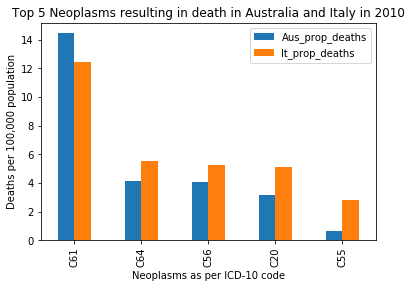

In [350]:
#plot 5 most common causes of death due to cancer
Aus_Ital_2010.iloc[[12, 13, 10, 4, 9]].plot(kind ='bar', x='neoplasms', y=['Aus_prop_deaths','It_prop_deaths'])
plt.xlabel('Neoplasms as per ICD-10 code')
plt.ylabel('Deaths per 100,000 population')
plt.title('Top 5 Neoplasms resulting in death in Australia and Italy in 2010')

In [351]:
Aus_Ital_2010.describe()

,Australia_deaths_2010,Aus_prop_deaths,Italy_deaths_2010,It_prop_deaths
count,19.000000,19.000000,19.000000,19.000000
mean,399.105263,1.782154,1181.842105,1.953995
std,781.244726,3.488550,1924.797746,3.182358
min,1.000000,0.004465,1.000000,0.001653
25%,19.000000,0.084842,56.500000,0.093414
50%,30.000000,0.133961,115.000000,0.190135
75%,442.000000,1.973695,1445.000000,2.389086
max,3236.000000,14.449949,7509.000000,12.414980


In Australia, the five most common neoplasms resulting in death in 2010 were C61 (prostate cancer), C19 (colon cancer), C64 (kidney cancer), C56 (ovarian cancer), C20 (rectal cancer). In Italy the most common neoplasms in 2010 were C61 (prostate cancer), C64 (kidney cancer), C56 (ovarian cancer), C20 (rectal cancer), C55 (uterine cancer).These are the same except for colon cancer (in Aus Italy top 5) and uterine cancer (In Italy top 5). Uterine cancer resulted in 0.6% deaths in Australia compared to 2.8% deaths in Italy. Whilst colon cancer resulted in 5% of deaths in Australia compared to 1.7% in Italy. It's possible though that for both these categories coding may mean that deaths are classified as ovarian (for uterine) and colon (for rectal) and vice-versa. As these can be difficult areas to accurately diagnose and seperate with metastatic disease.¶


#### Compare deaths due to neoplasms by age group in Australia compared to Italy in 2010

In [352]:
Australia_neoplasms2010_total = Australia_neoplasms2010.loc[['deaths_total']] #select deaths by age group in 2010

In [353]:
rule_1 = pop_by_age['Country']== 5020 #select Australia from population data frame
rule_2 = pop_by_age['Year']== 2010 #select 2010 from population data frame
rules = rule_1 & rule_2

In [354]:
Aus_pop_by_age_2010 = pop_by_age[rules] #apply selection for Australia and 2010

In [355]:
Aus_pop_by_age_2010.loc['total_population'] = Aus_pop_by_age_2010.sum(axis=0) #calculate total across age groups

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [356]:
Aus_pop_by_age_2010.head()

,Country,Year,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,Pop8,Pop9,...,Pop17,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26
9197,5020.0,2010.0,148602.0,152751.0,150726.0,147054.0,144820.0,700989.0,719857.0,770176.0,...,655174.0,603179.0,449449.0,343395.0,256917.0,188988.0,98056.0,31042.0,7006.0,0.0
9198,5020.0,2010.0,140766.0,144762.0,143595.0,138976.0,137916.0,664365.0,683971.0,728073.0,...,670031.0,608012.0,458728.0,366657.0,296145.0,250921.0,167271.0,68896.0,22168.0,0.0
total_population,10040.0,4020.0,289368.0,297513.0,294321.0,286030.0,282736.0,1365354.0,1403828.0,1498249.0,...,1325205.0,1211191.0,908177.0,710052.0,553062.0,439909.0,265327.0,99938.0,29174.0,0.0


In [357]:
Aus_pop_by_age_2010 = Aus_pop_by_age_2010.drop([9197, 9198], axis =0) #remove individual population estimates by sex

In [358]:
Aus_pop_by_age_2010 = Aus_pop_by_age_2010.drop(['Country', 'Year'], axis =1)

In [359]:
#create dictionary of deaths and population for each age group
Aus_population = {'Deaths2': 289368, 'Deaths3': 297513, 'Deaths4': 294321, 'Deaths5': 286030, 'Deaths6': 282736, 'Deaths7': 1365354, 'Deaths8': 1403828, 'Deaths9': 1498249, 'Deaths10': 1642263, 'Deaths11': 1657438, 'Deaths12':1528993, 'Deaths13': 1616023, 'Deaths14': 1549610, 'Deaths15': 1575858, 'Deaths16': 1467896, 'Deaths17' : 1325205, 'Deaths18' : 1211191, 'Deaths19': 908177, 'Deaths20': 710052, 'Deaths21': 553062, 'Deaths22': 439909, 'Deaths23': 265327, 'Deaths24': 99938, 'Deaths25': 29174, 'Deaths26': 0}

In [360]:
Aus_combined_2010 = Australia_neoplasms2010_total.append(Aus_population, ignore_index=True) #add to dataframe with deaths

In [361]:
Aus_combined_2010.loc['2'] = (Aus_combined_2010.iloc[0]/Aus_combined_2010.iloc[1])*100 #calculate age-specific mortality rate

In [362]:
Aus_combined_2010.sort_values('2', axis =1, ascending = False, kind='quicksort', na_position='last') #sort value

,Deaths26,Deaths24,Deaths25,Deaths23,Deaths22,Deaths21,Deaths20,Deaths19,Deaths18,Deaths17,...,Deaths7,Deaths2,Deaths8,Deaths6,Deaths4,Deaths3,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,5.000000,9389.000000,2380.000000,19998.000000,25967.000000,24598.000000,19613.000000,14797.000000,1.103700e+04,7.582000e+03,...,2.900000e+01,6.000000,2.700000e+01,5.000000,5.000000,5.000000,0.0,0.0,0.0,6.0
1,0.000000,99938.000000,29174.000000,265327.000000,439909.000000,553062.000000,710052.000000,908177.000000,1.211191e+06,1.325205e+06,...,1.365354e+06,289368.000000,1.403828e+06,282736.000000,294321.000000,297513.000000,NaN,NaN,NaN,NaN
2,inf,9.394825,8.157949,7.537115,5.902812,4.447603,2.762192,1.629308,9.112518e-01,5.721379e-01,...,2.123991e-03,0.002073,1.923313e-03,0.001768,0.001699,0.001681,NaN,NaN,NaN,NaN


Text(0.5,1,'Age-groups with the highest mortality rates from cancer in Australia in 2010')

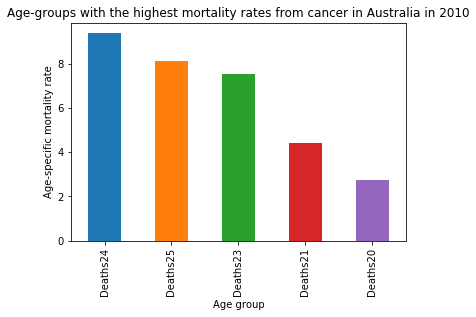

In [363]:
#plot bar chart
Aus_combined_2010.loc['2',['Deaths24', 'Deaths25', 'Deaths23','Deaths21','Deaths20']].plot(kind='bar', y= Aus_combined_2010.loc['2'])
plt.xlabel('Age group')
plt.ylabel('Age-specific mortality rate')
plt.title('Age-groups with the highest mortality rates from cancer in Australia in 2010')

In [364]:
Italy_neoplasms2010 = Italy_neoplasms[Italy_neoplasms['Year']==2010]

In [365]:
Italy_neoplasms2010 = Italy_neoplasms.drop(['Country', 'Deaths1','Year', 'List', 'Cause', 'Sex', 'Frmat',
       'IM_Frmat'], axis=1) #not needed for analysis

In [366]:
Italy_neoplasms2010 = Italy_neoplasms2010.set_index('neoplasms')

In [367]:
Italy_neoplasms2010.loc['deaths_total']= Italy_neoplasms2010.sum()

In [368]:
Italy_neoplasms2010.sort_values('deaths_total', axis =1, ascending = False, kind='quicksort', na_position='last')

,Deaths22,Deaths21,Deaths23,Deaths20,Deaths19,Deaths18,Deaths24,Deaths17,Deaths16,Deaths25,...,Deaths6,Deaths4,Deaths3,Deaths5,Deaths2,IM_Deaths4,Deaths26,IM_Deaths3,IM_Deaths1,IM_Deaths2
neoplasms,,,,,,,,,,,,,,,,,,,,,
C01,7.0,15.0,0.0,9.0,15.0,15.0,0.0,12.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C01,0.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C07,19.0,24.0,15.0,13.0,13.0,9.0,9.0,9.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C07,15.0,9.0,12.0,4.0,5.0,5.0,19.0,4.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12,4.0,6.0,0.0,8.0,3.0,10.0,0.0,2.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C19,74.0,96.0,31.0,87.0,69.0,45.0,15.0,29.0,22.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C19,86.0,78.0,49.0,61.0,34.0,29.0,34.0,27.0,8.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C20,261.0,357.0,147.0,307.0,277.0,188.0,56.0,114.0,82.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [369]:
Italy_neoplasms2010_total = Italy_neoplasms2010.loc[['deaths_total']]

In [370]:
rule_1i = pop_by_age['Country']== 4180
rule_2i = pop_by_age['Year']== 2010
rules = rule_1i & rule_2i

In [371]:
It_pop_by_age_2010 = pop_by_age[rules]

In [372]:
It_pop_by_age_2010.loc['total_population'] = It_pop_by_age_2010.sum(axis=0)

C:\Users\mokgor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [373]:
It_pop_by_age_2010.head()

,Country,Year,Pop2,Pop3,Pop4,Pop5,Pop6,Pop7,Pop8,Pop9,...,Pop17,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26
6213,4180.0,2010.0,287504.0,292981.0,294030.0,293783.0,293947.0,1458918.0,1447417.0,1519990.0,...,1807582.0,1814773.0,1468434.0,1400990.0,1078455.0,725761.0,371286.0,90114.0,29700.0,0.0
6214,4180.0,2010.0,271675.0,278129.0,279329.0,277815.0,276360.0,1379303.0,1364393.0,1431000.0,...,1908448.0,1942734.0,1639280.0,1667754.0,1453468.0,1186271.0,788191.0,247726.0,106576.0,0.0
total_population,8360.0,4020.0,559179.0,571110.0,573359.0,571598.0,570307.0,2838221.0,2811810.0,2950990.0,...,3716030.0,3757507.0,3107714.0,3068744.0,2531923.0,1912032.0,1159477.0,337840.0,136276.0,0.0


In [374]:
It_pop_by_age_2010 = It_pop_by_age_2010.drop([6213, 6214], axis =0)

In [375]:
It_pop_by_age_2010 = It_pop_by_age_2010.drop(['Country', 'Year'], axis =1)

In [376]:
It_population = {'Deaths2': 559179, 'Deaths3': 571110, 'Deaths4': 573359, 'Deaths5': 571598, 'Deaths6': 570307, 'Deaths7': 2838221, 'Deaths8': 2811810, 'Deaths9': 2950990, 'Deaths10': 3126504, 'Deaths11': 3487901, 'Deaths12':4132871, 'Deaths13': 4799943, 'Deaths14': 4949158, 'Deaths15': 4717717, 'Deaths16': 4095185, 'Deaths17' : 3716030, 'Deaths18' : 3757507, 'Deaths19': 3107714, 'Deaths20': 3068744, 'Deaths21': 2531923, 'Deaths22': 1912032, 'Deaths23': 1159477, 'Deaths24': 337840, 'Deaths25': 136276, 'Deaths26': 0}

In [377]:
It_combined_2010 = Italy_neoplasms2010_total.append(It_population, ignore_index=True)

In [378]:
It_combined_2010.loc['2'] = (It_combined_2010.iloc[0]/It_combined_2010.iloc[1])*100

In [379]:
It_combined_2010.sort_values('2', axis =1, ascending = False, kind='quicksort', na_position='last')

,Deaths26,Deaths24,Deaths25,Deaths23,Deaths22,Deaths21,Deaths20,Deaths19,Deaths18,Deaths17,...,Deaths4,Deaths3,Deaths5,Deaths7,Deaths2,Deaths8,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,2.000000,22893.000000,5929.000000,4.814900e+04,6.644200e+04,6.017400e+04,4.669000e+04,3.353500e+04,2.323600e+04,1.546400e+04,...,13.000000,12.000000,12.000000,5.000000e+01,6.000000,2.600000e+01,0.0,0.0,1.0,5.0
1,0.000000,337840.000000,136276.000000,1.159477e+06,1.912032e+06,2.531923e+06,3.068744e+06,3.107714e+06,3.757507e+06,3.716030e+06,...,573359.000000,571110.000000,571598.000000,2.838221e+06,559179.000000,2.811810e+06,NaN,NaN,NaN,NaN
2,inf,6.776285,4.350729,4.152648e+00,3.474942e+00,2.376613e+00,1.521469e+00,1.079089e+00,6.183887e-01,4.161430e-01,...,0.002267,0.002101,0.002099,1.761667e-03,0.001073,9.246713e-04,NaN,NaN,NaN,NaN


Text(0.5,1,'Age-groups with the highest mortality rates from cancer in Italy in 2010')

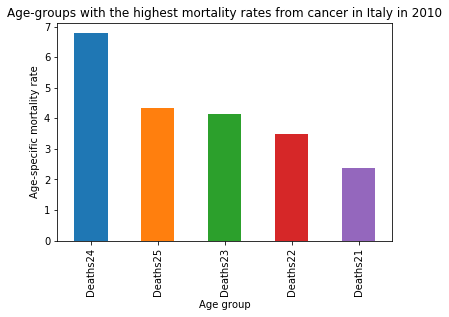

In [380]:
It_combined_2010.loc['2',['Deaths24', 'Deaths25', 'Deaths23','Deaths22','Deaths21']].plot(kind='bar', y= It_combined_2010.loc['2'])
plt.xlabel('Age group')
plt.ylabel('Age-specific mortality rate')
plt.title('Age-groups with the highest mortality rates from cancer in Italy in 2010')

Text(0.5,1,'Age-groups with the highest mortality rates from cancer in Australia in 2010')

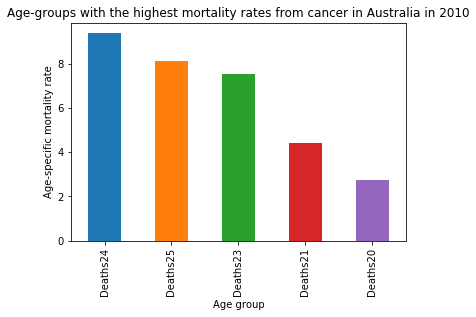

In [381]:
Aus_combined_2010.loc['2',['Deaths24', 'Deaths25', 'Deaths23','Deaths21','Deaths20']].plot(kind='bar', y= Aus_combined_2010.loc['2'])
plt.xlabel('Age group')
plt.ylabel('Age-specific mortality rate')
plt.title('Age-groups with the highest mortality rates from cancer in Australia in 2010')

In Australia and Italy the top 3 age groups with the highest mortality rates from cancer are Deaths24 (90-94 years), Deaths25(95 years and above ) and Deaths23(85-89 years). The next two top age groups in Australia were Deaths21(75-79) and Deaths20(70-74).
In Italy the next two were Deaths22 (80-84) and Deaths 21(75-79). The results are largely similar.

In Australia when age specific mortality rates were not taken into consideration, the age groups with the highest rate of mortality also presenting with a neoplasm were Deaths22 (age 80-84 years), Deaths21 (age 75-79 years), Deaths23 (85-89 years), Deaths20 (70-74 years), Deaths19 (65-69 years). Its clear that when age-specific mortality rates are taken into account the data are slightly different (Deaths19 is no longer in the top 5 for Australia and the rankings are also diferent).

Overall results should be interpreted carefully, there may be mulitple causes of death particularly in an older, sicker population and so it cannot be assumed deaths are due solely to cancer. Incidence rates can also be taken into account when considering the burden of disease.